<a href="https://colab.research.google.com/github/Manojkumar310897/Guvi-Final-projects/blob/main/Stock_Exchange.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Importing libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
import nltk
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Importing the dataset
import xml.etree.ElementTree as ET
#Parsing the xml file using element tree library
tree = ET.parse('/content/drive/MyDrive/Posts.xml')
root = tree.getroot()

In [6]:
# Define a function to extract features for each question
def extract_features(question):
    question_id = question.get('Id')
    view_count = int(question.get('ViewCount'))
    title_length = len(question.get('Title'))
    text_length = len(question.get('Body'))
    body = (question.get('Body'))
    comment_count = int(question.get('CommentCount'))
    score = int(question.get('Score'))
    answer_count = int(question.get('AnswerCount'))
    tag_length= len(question.get('Tags'))
    # Create a dictionary of features
    features = {
        'question_id': question_id,
        'view_count': view_count,
        'title_length': title_length,
        'text_length': text_length,
        'comment_count': comment_count,
        'score': score,
        'answer_count': answer_count,
        'body':body,
        'tags':tag_length
    }

    return features
#creating the target variable using the features    
def label_questions(df):
    df['quality'] = 'Very-low'
    df.loc[(df['score'] > 5) & (df['answer_count'] > 0), 'quality'] = 'Good'
    df.loc[(df['score'] >= 0) & (df['score'] <= 5) & (df['answer_count'] == 0), 'quality'] = 'Low'

    return df

In [7]:
# Extract features for each question and store them in a list of dictionaries
features = []
for question in root.findall('./row'):
    if question.get('PostTypeId') == '1':  # Only consider questions, not answers
        features.append(extract_features(question))

In [8]:
#creating the dataframes from the features
import pandas as pd
df=pd.DataFrame(features)

In [9]:
df = label_questions(df)

In [10]:
df.head()

,question_id,view_count,title_length,text_length,comment_count,score,answer_count,body,tags,quality
0,1,13803,50,248,5,76,5,<p>I often hear about subatomic particles havi...,69,Good
1,2,2641,55,170,4,29,4,<p>How would you explain string theory to non ...,26,Good
2,3,2412,48,808,5,35,3,<p>This is a question that has been posted at ...,55,Good
3,7,2033,34,135,5,10,6,<p>What are the main problems that we need to ...,91,Good
4,9,9277,20,257,2,48,6,<p>Hamilton's principle states that a dynamic ...,53,Good


In [11]:
df['WordCount'] = df['body'].apply(lambda x: len(x.split()))

In [12]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [15]:
# Tokenize the body text into words
df['tokens'] = df['body'].apply(nltk.word_tokenize)

# Tag each word with its part of speech
df['tagged'] = df['tokens'].apply(nltk.pos_tag)

# Count the number of nouns and pronouns in the body
df['nouns_count'] = df['tagged'].apply(lambda x: sum(1 for _, pos in x if pos.startswith('NN')))
df['pronouns_count'] = df['tagged'].apply(lambda x: sum(1 for _, pos in x if pos.startswith('PRP')))



In [17]:
# From  the scores we calculate the upvotes and downvotes
df['UpVotes'] = (df['score']+1)/2
df['DownVotes'] = (1-df['score'])/2

In [18]:
df.head()

,question_id,view_count,title_length,text_length,comment_count,score,answer_count,body,tags,quality,WordCount,tokens,tagged,nouns_count,pronouns_count,UpVotes,DownVotes
0,1,13803,50,248,5,76,5,<p>I often hear about subatomic particles havi...,69,Good,41,"[<, p, >, I, often, hear, about, subatomic, pa...","[(<, JJ), (p, NN), (>, NN), (I, PRP), (often, ...",11,3,38.5,-37.5
1,2,2641,55,170,4,29,4,<p>How would you explain string theory to non ...,26,Good,28,"[<, p, >, How, would, you, explain, string, th...","[(<, JJ), (p, NN), (>, NNP), (How, NNP), (woul...",6,5,15.0,-14.0
2,3,2412,48,808,5,35,3,<p>This is a question that has been posted at ...,55,Good,147,"[<, p, >, This, is, a, question, that, has, be...","[(<, JJ), (p, NN), (>, NN), (This, DT), (is, V...",49,11,18.0,-17.0
3,7,2033,34,135,5,10,6,<p>What are the main problems that we need to ...,91,Good,20,"[<, p, >, What, are, the, main, problems, that...","[(<, JJ), (p, NN), (>, VB), (What, WP), (are, ...",9,1,5.5,-4.5
4,9,9277,20,257,2,48,6,<p>Hamilton's principle states that a dynamic ...,53,Good,38,"[<, p, >, Hamilton, 's, principle, states, tha...","[(<, JJ), (p, NN), (>, NNP), (Hamilton, NNP), ...",19,1,24.5,-23.5


In [20]:
# calculate the length of each token list and store it in a new column
df["token_lengths"] = df["tokens"].apply(lambda x: [len(token) for token in x])

# sum the token lengths for each row and store the result in a new column
df["total_token_length"] = df["token_lengths"].apply(lambda x: sum(x))

# print the resulting DataFrame
print(df.head())


  question_id  view_count  title_length  text_length  comment_count  score  \
0           1       13803            50          248              5     76   
1           2        2641            55          170              4     29   
2           3        2412            48          808              5     35   
3           7        2033            34          135              5     10   
4           9        9277            20          257              2     48   

   answer_count                                               body  tags  \
0             5  <p>I often hear about subatomic particles havi...    69   
1             4  <p>How would you explain string theory to non ...    26   
2             3  <p>This is a question that has been posted at ...    55   
3             6  <p>What are the main problems that we need to ...    91   
4             6  <p>Hamilton's principle states that a dynamic ...    53   

  quality  WordCount                                             tokens  \

In [21]:
df['total_votes'] = df['UpVotes'] + df['DownVotes']

In [22]:
df.head()

,question_id,view_count,title_length,text_length,comment_count,score,answer_count,body,tags,quality,WordCount,tokens,tagged,nouns_count,pronouns_count,UpVotes,DownVotes,token_lengths,total_token_length,total_votes
0,1,13803,50,248,5,76,5,<p>I often hear about subatomic particles havi...,69,Good,41,"[<, p, >, I, often, hear, about, subatomic, pa...","[(<, JJ), (p, NN), (>, NN), (I, PRP), (often, ...",11,3,38.5,-37.5,"[1, 1, 1, 1, 5, 4, 5, 9, 9, 6, 1, 8, 6, 2, 4, ...",209,1.0
1,2,2641,55,170,4,29,4,<p>How would you explain string theory to non ...,26,Good,28,"[<, p, >, How, would, you, explain, string, th...","[(<, JJ), (p, NN), (>, NNP), (How, NNP), (woul...",6,5,15.0,-14.0,"[1, 1, 1, 3, 5, 3, 7, 6, 6, 2, 3, 10, 4, 2, 6,...",142,1.0
2,3,2412,48,808,5,35,3,<p>This is a question that has been posted at ...,55,Good,147,"[<, p, >, This, is, a, question, that, has, be...","[(<, JJ), (p, NN), (>, NN), (This, DT), (is, V...",49,11,18.0,-17.0,"[1, 1, 1, 4, 2, 1, 8, 4, 3, 4, 6, 2, 4, 9, 6, ...",658,1.0
3,7,2033,34,135,5,10,6,<p>What are the main problems that we need to ...,91,Good,20,"[<, p, >, What, are, the, main, problems, that...","[(<, JJ), (p, NN), (>, VB), (What, WP), (are, ...",9,1,5.5,-4.5,"[1, 1, 1, 4, 3, 3, 4, 8, 4, 2, 4, 2, 5, 2, 5, ...",115,1.0
4,9,9277,20,257,2,48,6,<p>Hamilton's principle states that a dynamic ...,53,Good,38,"[<, p, >, Hamilton, 's, principle, states, tha...","[(<, JJ), (p, NN), (>, NNP), (Hamilton, NNP), ...",19,1,24.5,-23.5,"[1, 1, 1, 8, 2, 9, 6, 4, 1, 7, 6, 6, 7, 1, 4, ...",218,1.0


In [48]:
df = df.drop(['tokens','tagged','body','question_id','token_lengths'],axis=1)

In [23]:
df.columns

Index(['question_id', 'view_count', 'title_length', 'text_length',
       'comment_count', 'score', 'answer_count', 'body', 'tags', 'quality',
       'WordCount', 'tokens', 'tagged', 'nouns_count', 'pronouns_count',
       'UpVotes', 'DownVotes', 'token_lengths', 'total_token_length',
       'total_votes'],
      dtype='object')

In [24]:
df['quality'].value_counts()

Very-low    101320
Low          22034
Good         15356
Name: quality, dtype: int64

In [25]:
((101320)/(101320+22034+15356))*100

73.04448129190398

In [26]:
((22034)/(101320+22034+15356))*100

15.884939802465576

In [27]:
((15356)/(101320+22034+15356))*100

11.070578905630452

The target data is imbalanced, because almost 73% of data is from Very-low.

1.MAJORITY CLASS is from Very-low (73.04%) 2.MINORITY CLASS is from Good (11.07%) 3.Other class is from Low(15.8%)

In [28]:
df.shape

(138710, 20)

In [29]:
df['quality']=df['quality'].map({'Very-low':1,'Low':2,'Good':0})

In [30]:
df['quality'].unique()

array([0, 1, 2])

# **1.Data Cleaning**

1.Checking for the null values

In [49]:
df.isnull().sum()

view_count            0
title_length          0
text_length           0
comment_count         0
score                 0
answer_count          0
tags                  0
quality               0
wordcount             0
nouns_count           0
pronouns_count        0
upvotes               0
downvotes             0
total_token_length    0
total_votes           0
dtype: int64

There are no null values in this dataset

# 2.Spelling correction

In [32]:
df.columns

Index(['question_id', 'view_count', 'title_length', 'text_length',
       'comment_count', 'score', 'answer_count', 'body', 'tags', 'quality',
       'WordCount', 'tokens', 'tagged', 'nouns_count', 'pronouns_count',
       'UpVotes', 'DownVotes', 'token_lengths', 'total_token_length',
       'total_votes'],
      dtype='object')

In [33]:
def rename_cols(dataframe):
  cols = [var.lower() for var in dataframe.columns]
  dataframe.columns = cols
  return dataframe

In [34]:
df=rename_cols(df)

# 3.**Checking Datatypes**

In [50]:
df.dtypes

view_count              int64
title_length            int64
text_length             int64
comment_count           int64
score                   int64
answer_count            int64
tags                    int64
quality                 int64
wordcount               int64
nouns_count             int64
pronouns_count          int64
upvotes               float64
downvotes             float64
total_token_length      int64
total_votes           float64
dtype: object

In [51]:
df.astype(int)

,view_count,title_length,text_length,comment_count,score,answer_count,tags,quality,wordcount,nouns_count,pronouns_count,upvotes,downvotes,total_token_length,total_votes
0,13803,50,248,5,76,5,69,0,41,11,3,38,-37,209,1
1,2641,55,170,4,29,4,26,0,28,6,5,15,-14,142,1
2,2412,48,808,5,35,3,55,0,147,49,11,18,-17,658,1
3,2033,34,135,5,10,6,91,0,20,9,1,5,-4,115,1
4,9277,20,257,2,48,6,53,0,38,19,1,24,-23,218,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138705,10,34,2156,0,0,0,53,2,157,258,9,0,0,1997,1
138706,9,73,2063,0,0,0,38,2,261,184,4,0,0,1823,1
138707,5,31,583,0,0,0,108,2,49,74,3,0,0,537,1
138708,8,86,641,2,0,0,38,2,94,79,4,0,0,548,1


# **4.Removing the duplicates**

In [97]:
df.duplicated().sum()

0

In [98]:
df=df.drop_duplicates()

# **5.Checking for the outliers**

In [99]:
df.describe()

,view_count,title_length,text_length,comment_count,score,answer_count,tags,quality,wordcount,nouns_count,pronouns_count,upvotes,downvotes,total_token_length,total_votes
count,138710.000000,138710.000000,138710.000000,138710.000000,138710.000000,138710.000000,138710.000000,138710.000000,138710.000000,138710.000000,138710.000000,138710.000000,138710.000000,138710.000000,138710.0
mean,1320.033566,57.117281,902.609221,2.393021,2.668661,1.478920,49.503150,1.048144,131.007887,73.011866,6.633451,1.834331,-0.834331,770.265035,1.0
std,6404.536977,24.494070,834.827198,2.874588,7.482525,1.307238,22.928833,0.516952,114.896389,76.544226,6.570147,3.741262,3.741262,721.805789,0.0
min,3.000000,15.000000,38.000000,0.000000,-24.000000,0.000000,5.000000,0.000000,4.000000,2.000000,0.000000,-11.500000,-340.500000,32.000000,1.0
25%,83.000000,39.000000,386.000000,0.000000,0.000000,1.000000,32.000000,1.000000,59.000000,27.000000,2.000000,0.500000,-1.000000,326.000000,1.0
50%,217.000000,53.000000,674.000000,2.000000,1.000000,1.000000,48.000000,1.000000,100.000000,51.000000,5.000000,1.000000,0.000000,571.000000,1.0
75%,716.000000,71.000000,1143.000000,4.000000,3.000000,2.000000,66.000000,1.000000,166.000000,92.000000,9.000000,2.000000,0.500000,972.000000,1.0
max,785052.000000,150.000000,30528.000000,67.000000,682.000000,49.000000,129.000000,2.000000,3206.000000,4205.000000,279.000000,341.500000,12.500000,27778.000000,1.0


/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='view_count'>

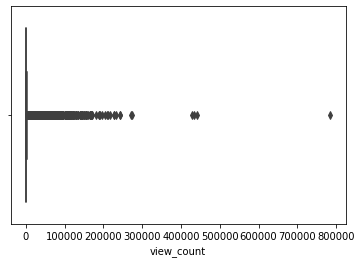

In [100]:
import seaborn as sns
sns.boxplot(df['view_count'])

Acccording to the box plot view_count is having some outliers.Minimum count=3,Maximum count=785052.

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='title_length'>

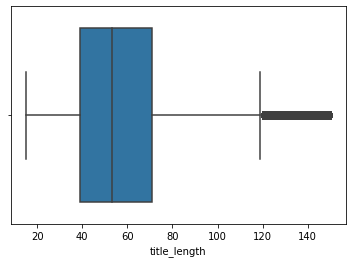

In [101]:
sns.boxplot(df['title_length'])

TITLE LENGTH: Having a valid outlier because most of the data lie in the range...min length-16,max length-150

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='text_length'>

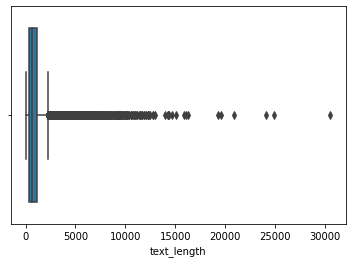

In [102]:
sns.boxplot(df['text_length'])

TEXT LENGTH: The text length of each question can vary ,so the text length does not lie in the quartile range...min length-38,max length-30528

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='comment_count'>

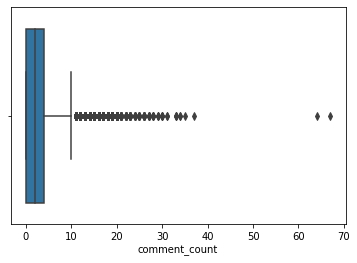

In [103]:
sns.boxplot(df['comment_count'])

COMMENT COUNT: Having some outlier...min count-0,max count-67

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='upvotes'>

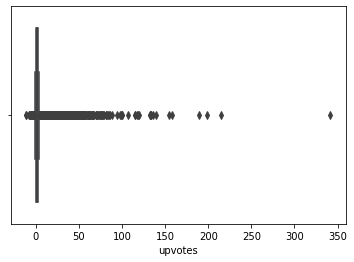

In [105]:
sns.boxplot(df['upvotes'])

UPVOTES: Having some outlier...min count -11,max count-340

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='downvotes'>

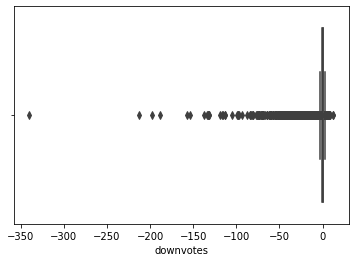

In [106]:
sns.boxplot(df['downvotes'])

DOWNVOTES: Having some outliers ,if we remove the outliers it will impact the results

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='wordcount'>

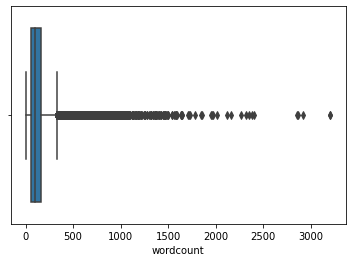

In [107]:
sns.boxplot(df['wordcount'])

WORD COUNT: Having some outlier...min count-4,max count-3206

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='tags'>

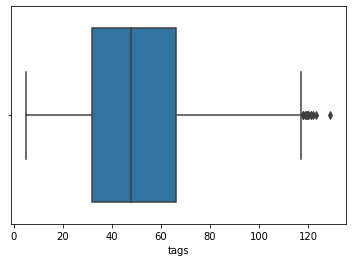

In [108]:
sns.boxplot(df['tags'])

Tags: Having some valid outlier,because most of the data lie in the range....min count-5,max count-129

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='nouns_count'>

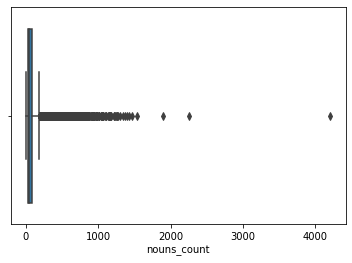

In [109]:
sns.boxplot(df['nouns_count'])

NOUNS COUNT: Having some valid outlier,because most of the data lie in the range....min count-2,max count-4205

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pronouns_count'>

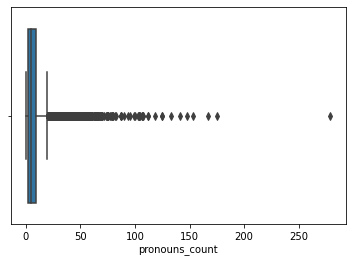

In [110]:
sns.boxplot(df['pronouns_count'])

PRONOUNS COUNT: Having some valid outlier,because most of the data lie in the range....min count-0,max count-279

# Explanatory Data Analysis

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='view_count', ylabel='Density'>

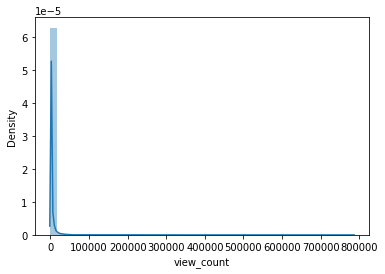

In [111]:
sns.distplot(df['view_count'])

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='title_length', ylabel='Density'>

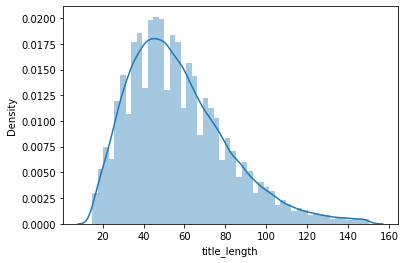

In [112]:
sns.distplot(df['title_length'])

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='text_length', ylabel='Density'>

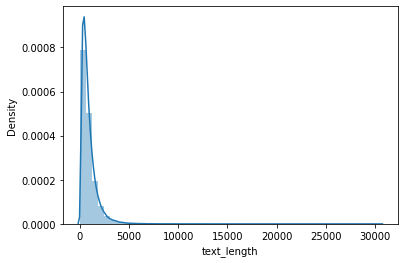

In [113]:
sns.distplot(df['text_length'])

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='comment_count', ylabel='Density'>

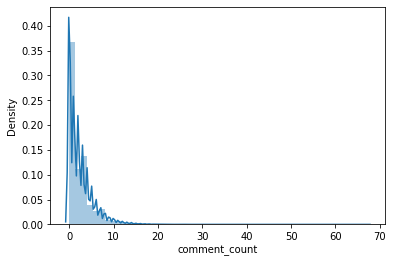

In [114]:
sns.distplot(df['comment_count'])

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='upvotes', ylabel='Density'>

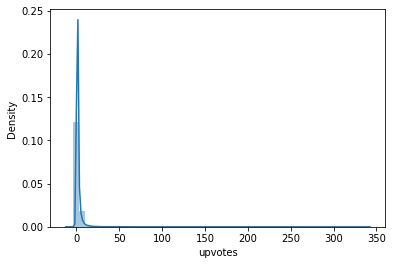

In [115]:
sns.distplot(df['upvotes'])

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='downvotes', ylabel='Density'>

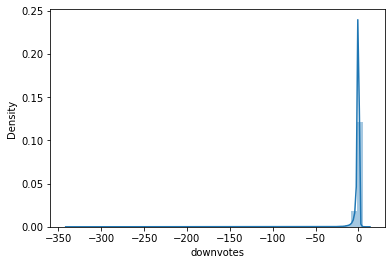

In [116]:
sns.distplot(df['downvotes'])

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='wordcount', ylabel='Density'>

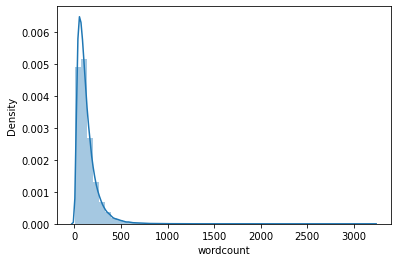

In [117]:
sns.distplot(df['wordcount'])

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='tags', ylabel='Density'>

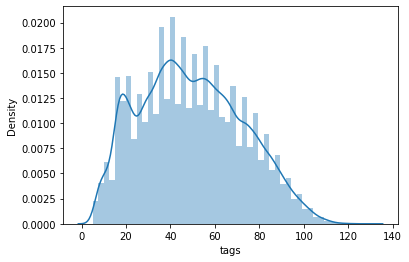

In [118]:
sns.distplot(df['tags'])

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_token_length', ylabel='Density'>

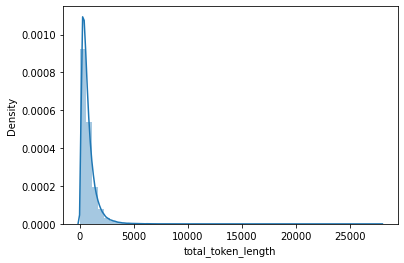

In [119]:
sns.distplot(df['total_token_length'])

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='nouns_count', ylabel='Density'>

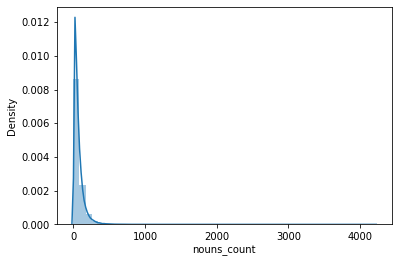

In [120]:
sns.distplot(df['nouns_count'])

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pronouns_count', ylabel='Density'>

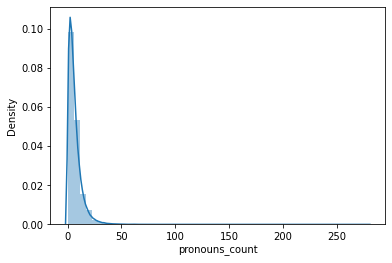

In [121]:
sns.distplot(df['pronouns_count'])

Plotting the distplot for checking the distribution of features

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


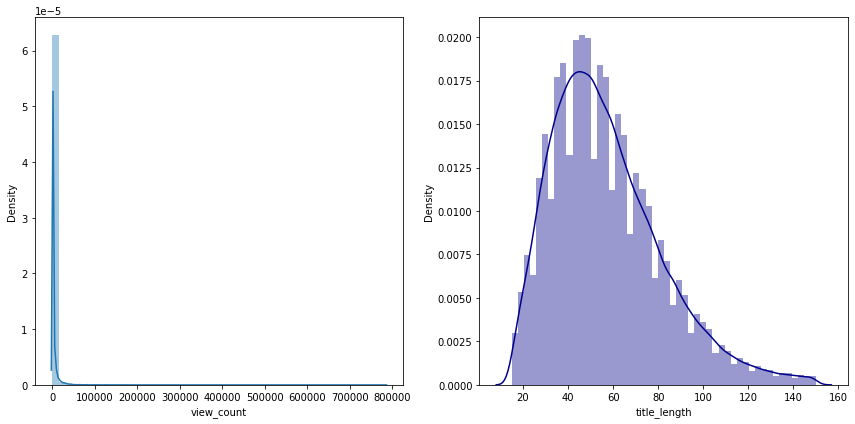

In [122]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.distplot(df['view_count'])
plt.subplot(1,2,2)
sns.distplot(df['title_length'],color = 'darkblue')
plt.tight_layout()

1.The maximum view_count lies below 100000 and some values are dispersed and max value upto 785000


2.The title length is mostly distributed between 20 and 140

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


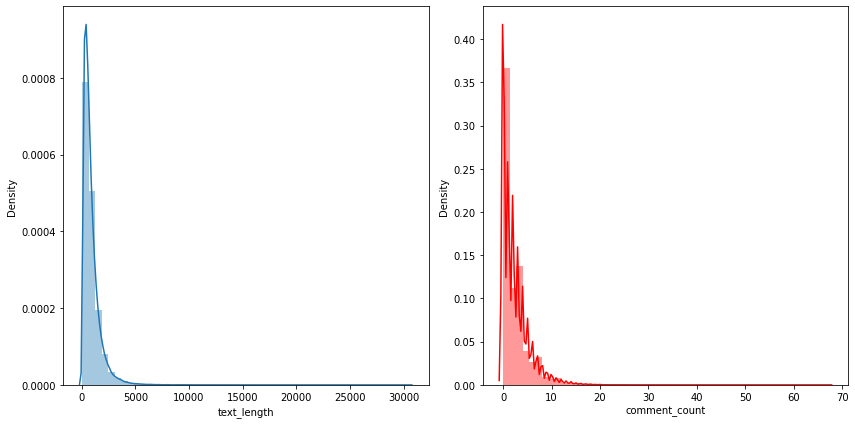

In [123]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.distplot(df['text_length'])
plt.subplot(1,2,2)
sns.distplot(df['comment_count'],color = 'red')
plt.tight_layout()

1.The maximum text length is distributed between 0 and 5000.


2.The no of comments are distributed between 0 and 15 and max value extends upto 60

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


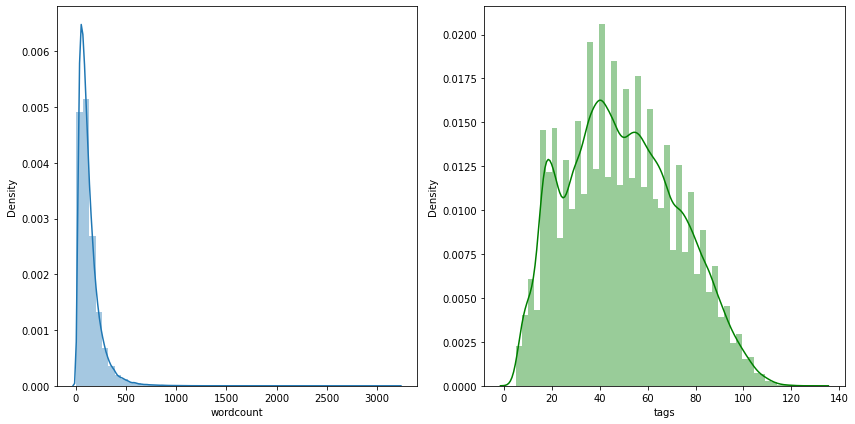

In [124]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.distplot(df['wordcount'])
plt.subplot(1,2,2)
sns.distplot(df['tags'],color = 'green')
plt.tight_layout()

1.The no of word counts in a question are mostly distributed between 0 and 500.



2.The no of tags are mostly distributed between 0 and 120.

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


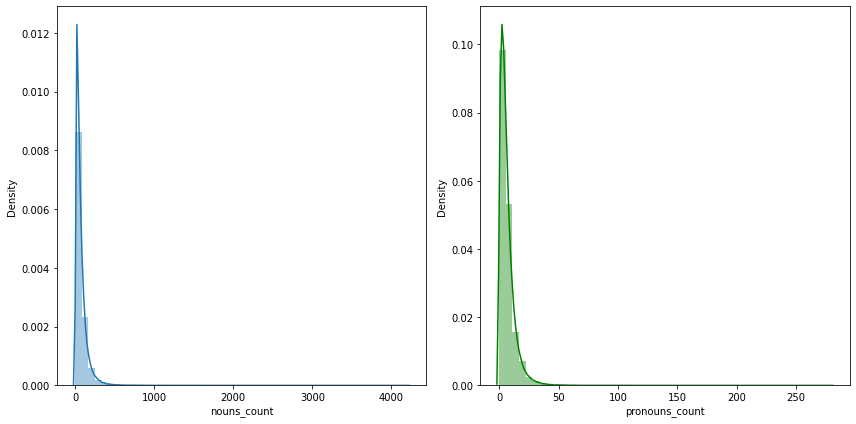

In [125]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.distplot(df['nouns_count'])
plt.subplot(1,2,2)
sns.distplot(df['pronouns_count'],color = 'green')
plt.tight_layout()

1.The no of noun counts in a question are mostly distributed between 0 and 300.


2.The no of pronoun counts in a question are mostly distributed between 0 and 45.

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


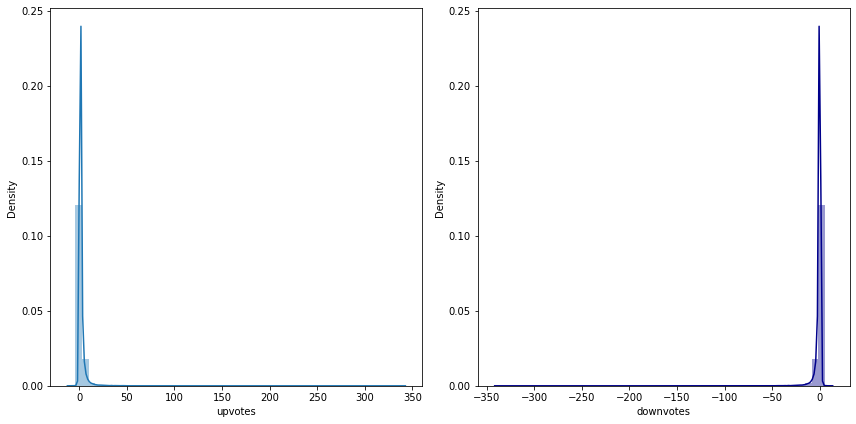

In [126]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.distplot(df['upvotes'])
plt.subplot(1,2,2)
sns.distplot(df['downvotes'],color = 'darkblue')
plt.tight_layout()

1.The no of upvotes are distributed between negative values and upto 40 .Max value is 340.


2.The downvotes are distributed in negative values between 0 and -30

# FEATURE VS TARGET

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


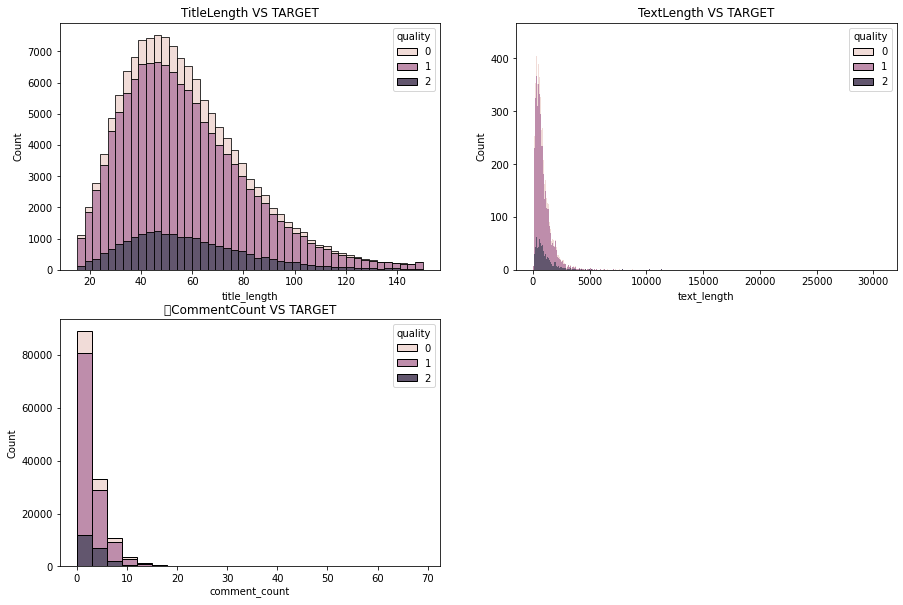

<Figure size 432x288 with 0 Axes>

In [127]:
plt.figure(figsize=(15,10))

plt.subplot(221)
sns.histplot(data=df, x="title_length", hue="quality", multiple="stack",binwidth=3)
plt.title('TitleLength VS TARGET')

plt.subplot(222)
sns.histplot(data=df, x="text_length", hue="quality", multiple="stack",binwidth=3)
plt.title('TextLength VS TARGET')

plt.subplot(223)
sns.histplot(data=df, x="comment_count", hue="quality", multiple="stack",binwidth=3)
plt.title('	CommentCount VS TARGET')
plt.show()
plt.tight_layout()
     

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


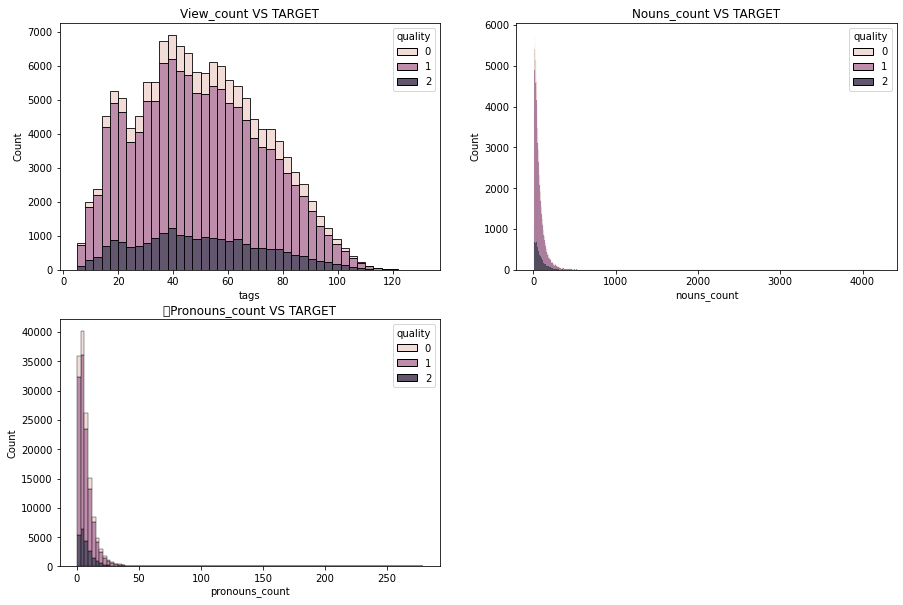

<Figure size 432x288 with 0 Axes>

In [136]:
plt.figure(figsize=(15,10))

plt.subplot(221)
sns.histplot(data=df, x="tags", hue="quality", multiple="stack",binwidth=3)
plt.title('View_count VS TARGET')

plt.subplot(222)
sns.histplot(data=df, x="nouns_count", hue="quality", multiple="stack",binwidth=3)
plt.title('Nouns_count VS TARGET')

plt.subplot(223)
sns.histplot(data=df, x="pronouns_count", hue="quality", multiple="stack",binwidth=3)
plt.title('	Pronouns_count VS TARGET')
plt.show()
plt.tight_layout()

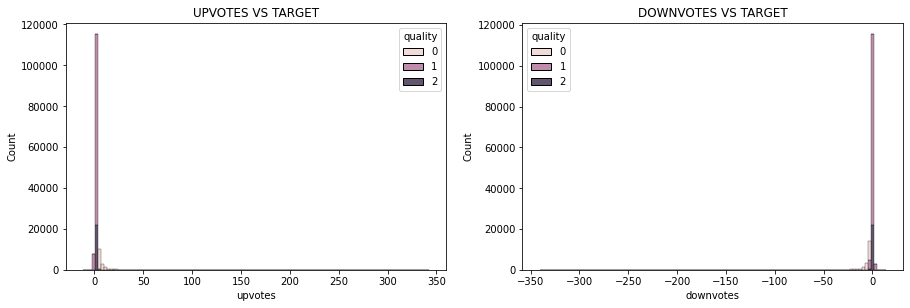

<Figure size 432x288 with 0 Axes>

In [130]:
plt.figure(figsize=(15,10))

plt.subplot(221)
sns.histplot(data=df, x="upvotes", hue="quality", multiple="stack",binwidth=3)
plt.title('UPVOTES VS TARGET')

plt.subplot(222)
sns.histplot(data=df, x="downvotes", hue="quality", multiple="stack",binwidth=3)
plt.title('DOWNVOTES VS TARGET')

plt.show()
plt.tight_layout()

# **INTERPRETATIONS**

1.FROM TITLE LENGTH VS TARGET When the title_length is high the quality of the decreases

2.FROM TEXT LENGTH VS TARGET  When the text length is low the quality of the question tends to be low.

3.FROM COMMENT COUNT VS TARGET , When the comment counts are low the quality of the question seems to be low. 

4.FROM TAGS VS TARGET , When the no of tags are high the quality seems to be good.Tags play an important role

5.FROM NOUNS VS TARGET ,The nouns count doesnt seem to play an important role in predicting quality of the question

6.FROM UPVOTES VS TARGET , When the upvotes are high in postive values the question seems to be good quality question

*From this plot itself we came to know there is an imbalance data in target variable. 

# **FEATURE ANALYSIS**

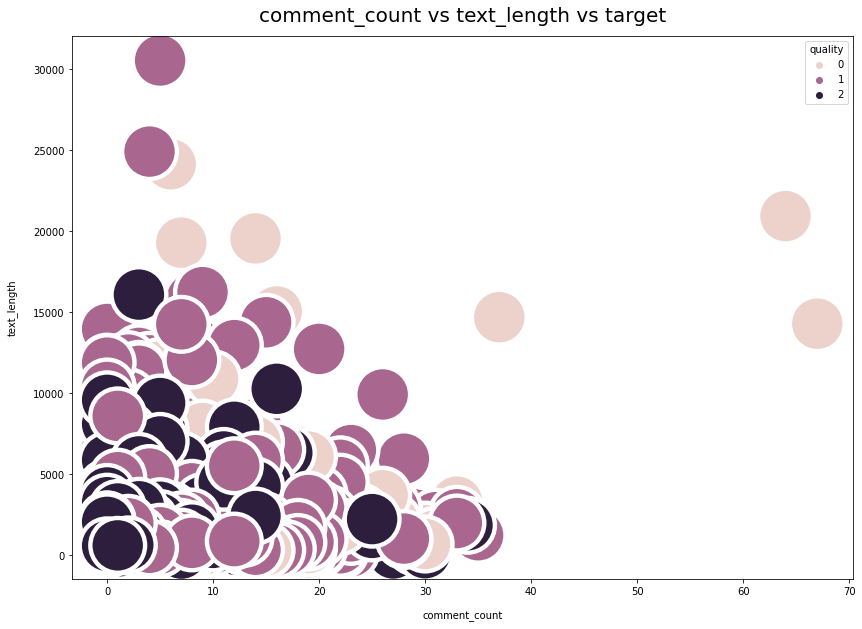

In [131]:
import seaborn as sns
plt.figure(figsize=(14,10))
sns.scatterplot(x='comment_count', y='text_length', hue='quality', data=df, s=3000)
plt.title("comment_count vs text_length vs target", y=1.015, fontsize=20)
plt.xlabel("comment_count", labelpad=15)
plt.ylabel("text_length", labelpad=15)
ax = plt.gca()

When the comment counts are high question quality  is good and when comments are low quality is very low.The text length dosent play important role.

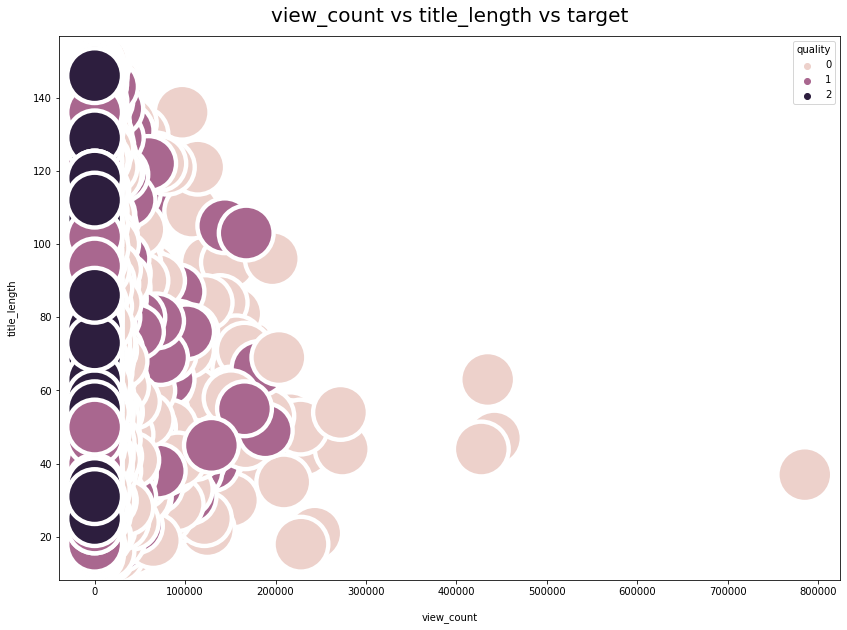

In [132]:
import seaborn as sns
plt.figure(figsize=(14,10))
sns.scatterplot(x='view_count', y='title_length', hue='quality', data=df, s=3000)
plt.title("view_count vs title_length vs target", y=1.015, fontsize=20)
plt.xlabel("view_count", labelpad=15)
plt.ylabel("title_length", labelpad=15)
ax = plt.gca()

When the view count is high the question quality seems to good.View count plays an important role in predicting the quality of the question.

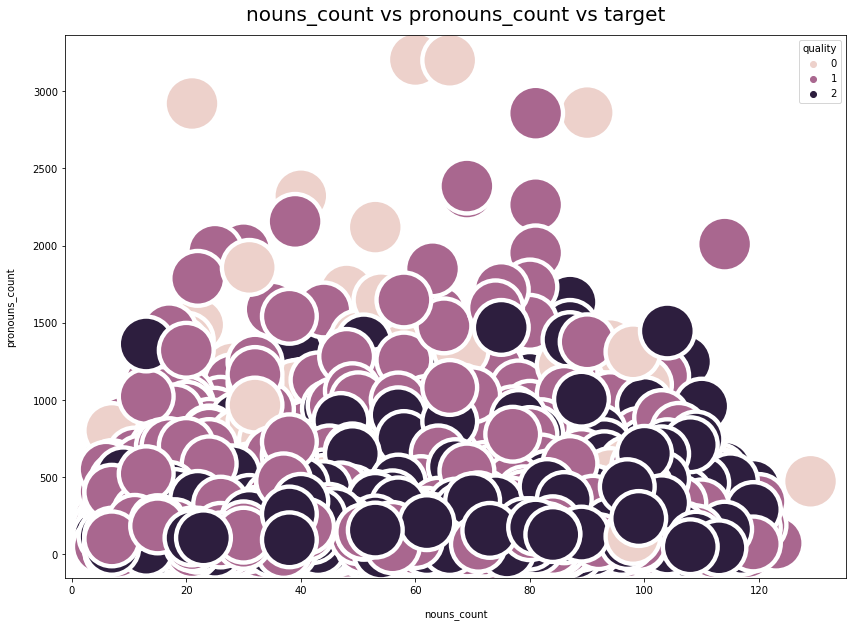

In [134]:
import seaborn as sns
plt.figure(figsize=(14,10))
sns.scatterplot(x='tags', y='wordcount', hue='quality', data=df, s=3000)
plt.title("nouns_count vs pronouns_count vs target", y=1.015, fontsize=20)
plt.xlabel("nouns_count", labelpad=15)
plt.ylabel("pronouns_count", labelpad=15)
ax = plt.gca()

When noun counts are high question quality seems to be low and when pronoun counts are high question quality seems to be good.

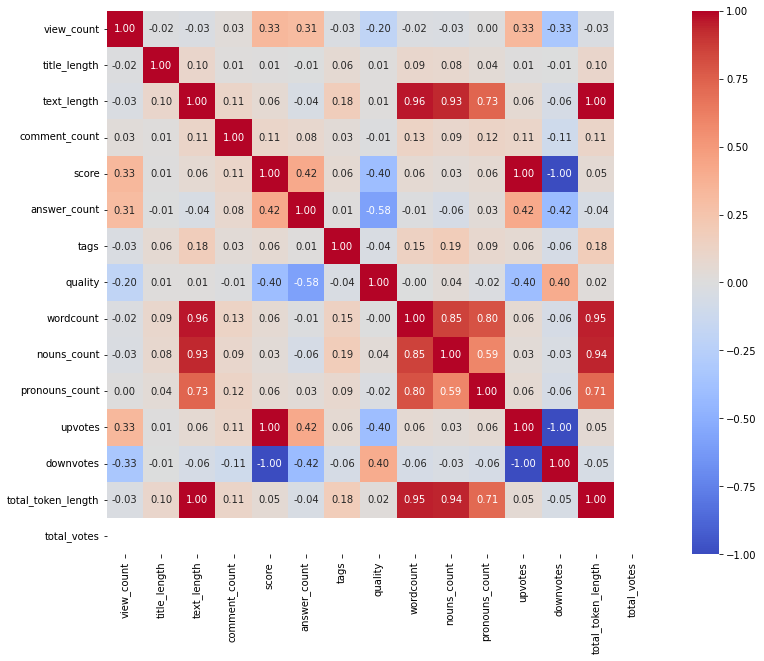

In [135]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(15, 10)) 
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f', square=True)
plt.show()

From the correlation matrix the score,answer count,upvotes are highly negatively correlated with the target variable.So we can remove them while creating the model

# TARGET AND FEATURE SELECTION

In [139]:
X = df.drop(['score','answer_count','quality','upvotes'],axis=1)
y = df['quality'].values

In [140]:
#Splitting the data into training and testing
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=0)

In [141]:
#Scaling the data using Standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [142]:
X_train

,view_count,title_length,text_length,comment_count,tags,wordcount,nouns_count,pronouns_count,downvotes,total_token_length,total_votes
134165,26,34,257,1,45,47,16,2,1.5,210,1.0
85144,329,69,4269,0,30,644,280,33,-2.0,3623,1.0
36449,856,46,402,0,38,59,27,6,-0.5,341,1.0
6495,156,49,392,4,78,56,23,7,-0.5,335,1.0
133719,45,43,190,1,36,15,27,0,2.0,179,1.0
...,...,...,...,...,...,...,...,...,...,...,...
41993,802,50,817,0,44,98,65,2,-3.5,729,1.0
97639,235,60,829,2,75,116,97,3,0.5,711,1.0
95939,298,125,624,2,29,113,60,6,-1.0,506,1.0
117952,55,35,578,0,16,70,51,5,0.5,508,1.0


In [143]:
X_train_scaled.shape

(110968, 11)

In [144]:
y_train.shape

(110968,)

# **ADASYN**

In [145]:
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


adasyn = ADASYN(random_state=42)

# Fit and transform the training data
X_resampled, y_resampled = adasyn.fit_resample(X_train_scaled, y_train)

# Train your model on the resampled data
model = LogisticRegression(random_state=42).fit(X_resampled, y_resampled)

# Evaluate your model on the test data
y_pred = model.predict(X_test_scaled)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [146]:
import collections, numpy
counter = collections.Counter(y_resampled)
counter

Counter({1: 81048, 2: 83922, 0: 81882})

In [176]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

LR = LogisticRegression()
LR.fit(X_resampled,y_resampled)
LR.score(X_resampled,y_resampled)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.796031630288594

# Random Undersampling:

In [147]:
from imblearn.under_sampling import RandomUnderSampler #  import 
rus = RandomUnderSampler() #Intialise the model
X_rus, y_rus = rus.fit_resample(X_train_scaled, y_train) #resampling the data 

In [148]:
import collections, numpy
counter = collections.Counter(y_rus)
counter

Counter({0: 12303, 1: 12303, 2: 12303})

In [172]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

LR = LogisticRegression()
LR.fit(X_rus,y_rus)
LR.score(X_rus,y_rus)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8017556693489393

# Random Oversampling:

In [149]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler() #Initialis the model 
X_ros, y_ros = ros.fit_resample(X_train_scaled, y_train) #Fit the model

In [150]:
import collections, numpy
counter = collections.Counter(y_ros)
counter

Counter({1: 81048, 2: 81048, 0: 81048})

In [173]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

LR = LogisticRegression()
LR.fit(X_ros,y_ros)
LR.score(X_ros,y_ros)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8035937551409864

# SMOTE:

In [151]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X_train_scaled, y_train)

In [152]:
import collections, numpy
counter = collections.Counter(y_sm)
counter

Counter({1: 81048, 2: 17617, 0: 81048})

In [174]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

LR = LogisticRegression()
LR.fit(X_sm,y_sm)
LR.score(X_sm,y_sm)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8994953064052128

# SMOTENN:

In [153]:
from imblearn.combine import SMOTEENN 
smt = SMOTEENN(sampling_strategy='all') 
X_smt, y_smt = smt.fit_resample(X_train_scaled, y_train) 

In [154]:
import collections, numpy
counter = collections.Counter(y_smt)
counter

Counter({0: 80776, 1: 35774, 2: 73827})

In [175]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

LR = LogisticRegression()
LR.fit(X_smt,y_smt)
LR.score(X_smt,y_smt)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8799172168906958

**To balance the data:**

1.ADASYN the model score is 79.60%.

2.For Random under sampling , the model score is 80.17%.

3.For Random over sampling , the model score is 80.35%.

4.SMOTE, the model score is 89.94%.

5.SMOTE + Tomek, the model score is 87.99%.

Here we got the best score from SMOTE which is 89.94%.

Now,We gonna use SMOTE technique to build the models

# 1.Logistic Regression

In [178]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
lr.fit(X_sm, y_sm)
predictions = lr.predict(X_smt)

# Printing the accuracy
accuracy = accuracy_score(y_smt, predictions)
print("Accuracy:", accuracy) 


Accuracy: 0.6182049302174107


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [177]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize logistic regression model
clf = LogisticRegression()

# Fit the model on training data
clf.fit(X_sm,y_sm)

# Make predictions on training data
train_preds = clf.predict(X_sm)

# Calculate training accuracy
train_acc = accuracy_score(y_sm, train_preds)

# Make predictions on testing data
test_preds = clf.predict(X_test_scaled)

# Calculate testing accuracy
test_acc = accuracy_score(y_test, test_preds)

print('Training Accuracy:', train_acc)
print('Testing Accuracy:', test_acc)


Training Accuracy: 0.8994953064052128
Testing Accuracy: 0.8371782856318939


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 2.**Random Forest Classifier**

In [179]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=150, max_depth=20, random_state=0)
rf_model.fit(X_sm,y_sm)

RandomForestClassifier(max_depth=20, n_estimators=150, random_state=0)

In [180]:

# Fit the model on training data
rf_model.fit(X_sm,y_sm)

# Make predictions on training data
train_preds = rf_model.predict(X_sm)

# Calculate training accuracy
train_acc = accuracy_score(y_sm, train_preds)

# Make predictions on testing data
test_preds = rf_model.predict(X_test_scaled)

# Calculate testing accuracy
test_acc = accuracy_score(y_test, test_preds)

print('Training Accuracy:', train_acc)
print('Testing Accuracy:', test_acc)

Training Accuracy: 0.9652334555652624
Testing Accuracy: 0.8595631172950761


In [181]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
# predict on the test data
y_pred = rf_model.predict(X_test_scaled)

# calculate evaluation metrics

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred)

# print the evaluation metrics
print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))
print(report)


Accuracy: 0.860
Precision: 0.841
Recall: 0.860
F1 Score: 0.835
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3053
           1       0.86      0.97      0.91     20272
           2       0.67      0.27      0.39      4417

    accuracy                           0.86     27742
   macro avg       0.83      0.75      0.76     27742
weighted avg       0.84      0.86      0.84     27742



#3. XGBoost

In [182]:
# Import necessary libraries
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Build the XGBoost model
model = xgb.XGBClassifier(objective='multi:softmax', num_class=3)
model.fit(X_sm,y_sm)

# Predict the labels for the test set
y_pred = model.predict(X_test_scaled)


# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy: ", accuracy)
print("F1 score: ", f1)
print("Confusion Matrix: \n", matrix)
print("classification_report",report)

Accuracy:  0.8604642779900512
F1 score:  0.8381055999424846
Confusion Matrix: 
 [[ 3046     7     0]
 [   82 19527   663]
 [    0  3119  1298]]
classification_report               precision    recall  f1-score   support

           0       0.97      1.00      0.99      3053
           1       0.86      0.96      0.91     20272
           2       0.66      0.29      0.41      4417

    accuracy                           0.86     27742
   macro avg       0.83      0.75      0.77     27742
weighted avg       0.84      0.86      0.84     27742



# 4.Decision Tree classifier

In [183]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

In [184]:
dtc=DecisionTreeClassifier(max_depth=20, random_state=42)
dtc.fit(X_sm,y_sm) 

DecisionTreeClassifier(max_depth=20, random_state=42)

In [185]:
from sklearn.model_selection import cross_val_score #this will help me to do cross- validation
import numpy as np

for depth in [1,2,3,4,5,6,7,8,9,10,20,40,60]:
  dt = DecisionTreeClassifier(max_depth=depth) # will tell the DT to not grow past the given threhsold
  # Fit dt to the training set
  dt.fit(X_ros,y_ros) # the model is trained
  trainAccuracy = accuracy_score(y_ros,dt.predict(X_ros)) # this is useless information - i am showing to prove a point
  dt = DecisionTreeClassifier(max_depth=depth) # a fresh model which is not trained yet
  valAccuracy = cross_val_score(dt, X_test_scaled, y_test, cv=10) # syntax : cross_val_Score(freshModel,fts, target, cv= 10/5)
  print("Depth  : ", depth, " Training Accuracy : ", trainAccuracy, " Cross val score : " ,np.mean(valAccuracy))

Depth  :  1  Training Accuracy :  0.6666666666666666  Cross val score :  0.8377550095156441
Depth  :  2  Training Accuracy :  0.7837413220149376  Cross val score :  0.8377550095156441
Depth  :  3  Training Accuracy :  0.7975315039647287  Cross val score :  0.8447839851387074
Depth  :  4  Training Accuracy :  0.797547955121245  Cross val score :  0.8503713374513664
Depth  :  5  Training Accuracy :  0.8057118415424604  Cross val score :  0.8530027864923323
Depth  :  6  Training Accuracy :  0.8226606455433817  Cross val score :  0.8545888007690458
Depth  :  7  Training Accuracy :  0.8248733260948244  Cross val score :  0.8557782757523205
Depth  :  8  Training Accuracy :  0.8301500345474286  Cross val score :  0.8550573212000755
Depth  :  9  Training Accuracy :  0.8316964432599612  Cross val score :  0.8525342400800223
Depth  :  10  Training Accuracy :  0.8366523541604974  Cross val score :  0.8486773969355079
Depth  :  20  Training Accuracy :  0.9386947652419965  Cross val score :  0.8021

In [186]:
y_pred = dtc.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred)

# print the evaluation metrics
print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))
print('Classification Report:\n', report)


Accuracy: 0.818
Precision: 0.805
Recall: 0.818
F1 Score: 0.811
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      3053
           1       0.86      0.90      0.88     20272
           2       0.43      0.35      0.39      4417

    accuracy                           0.82     27742
   macro avg       0.76      0.74      0.75     27742
weighted avg       0.80      0.82      0.81     27742



# 5.Gradient Boosting Classifier

In [187]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



# Initialize the Gradient Boosting Classifier with desired hyperparameters
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.2, max_depth=6, random_state=42)

# Fit the classifier to the training data
clf.fit(X_sm, y_sm)

# Make predictions on the test data
y_pred = clf.predict(X_test_scaled)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print("Accuracy:", accuracy)


Accuracy: 0.8585177708889049


# **6.K neigbor's classifier**

In [188]:

from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import cross_val_score 
for i in [1,2,3,4,5,6,7,8,9,10,20,30,40,50]: 
  knn= KNeighborsClassifier(i)
  knn.fit(X_sm, y_sm) 
  print("K value :", i, "Cross Value Accuracy :" , np.mean(cross_val_score(knn, X_test, y_test, cv=10)))

K value : 1 Cross Value Accuracy : 0.6243237917080743
K value : 2 Cross Value Accuracy : 0.6455916262332989
K value : 3 Cross Value Accuracy : 0.6743924602324025
K value : 4 Cross Value Accuracy : 0.6912259656917191
K value : 5 Cross Value Accuracy : 0.7013550926557416
K value : 6 Cross Value Accuracy : 0.7088890404463584
K value : 7 Cross Value Accuracy : 0.7132504530485786
K value : 8 Cross Value Accuracy : 0.7172158459829693
K value : 9 Cross Value Accuracy : 0.7185494001571868
K value : 10 Cross Value Accuracy : 0.7224063732081035
K value : 20 Cross Value Accuracy : 0.7319587806985067
K value : 30 Cross Value Accuracy : 0.7326074943003565
K value : 40 Cross Value Accuracy : 0.7338691972433862
K value : 50 Cross Value Accuracy : 0.7321390648038089


In [189]:
knn= KNeighborsClassifier(i)
knn.fit(X_sm, y_sm)
print(knn.score(X_sm,y_sm)) 

0.8780388730920968


FEATURE IMPORTANCE OF ALL MODELS

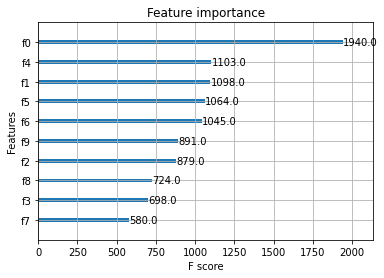

In [168]:
from xgboost import plot_importance

# plot feature importance
plot_importance(model)
plt.show()

In [169]:

importance = dtc.feature_importances_
list(zip(importance,['view_count', 'title_length', 'text_length', 'comment_count', 
       'tags',  'wordcount', 'nouns_count',
       'pronouns_count', 'downvotes', 'total_token_length',
       'total_votes']))
     

[(0.14157002557406487, 'view_count'),
 (0.031984520252516566, 'title_length'),
 (0.02265128625666562, 'text_length'),
 (0.03334781932466286, 'comment_count'),
 (0.030967566834987033, 'tags'),
 (0.03174877882024522, 'wordcount'),
 (0.03290341737719415, 'nouns_count'),
 (0.019776297528004902, 'pronouns_count'),
 (0.6271808239863064, 'downvotes'),
 (0.027869464045352406, 'total_token_length'),
 (0.0, 'total_votes')]

In [170]:
importance = rf_model.feature_importances_
list(zip(importance,['view_count', 'title_length', 'text_length', 'comment_count', 
       'tags',  'wordcount', 'nouns_count',
       'pronouns_count', 'downvotes', 'total_token_length',
       'total_votes']))

[(0.23590099683045165, 'view_count'),
 (0.03065147659230473, 'title_length'),
 (0.032545732984580064, 'text_length'),
 (0.03105027741560367, 'comment_count'),
 (0.03064903670363394, 'tags'),
 (0.03063310820777546, 'wordcount'),
 (0.030029332372463892, 'nouns_count'),
 (0.01998487521090477, 'pronouns_count'),
 (0.5242099483421783, 'downvotes'),
 (0.03434521534010375, 'total_token_length'),
 (0.0, 'total_votes')]

In [171]:
importance = model.feature_importances_
list(zip(importance,['view_count', 'title_length', 'text_length', 'comment_count', 
       'tags',  'wordcount', 'nouns_count',
       'pronouns_count', 'downvotes', 'total_token_length',
       'total_votes']))

[(0.07227092, 'view_count'),
 (0.0048337197, 'title_length'),
 (0.0062410682, 'text_length'),
 (0.03803329, 'comment_count'),
 (0.005683147, 'tags'),
 (0.0060111512, 'wordcount'),
 (0.007383718, 'nouns_count'),
 (0.005259748, 'pronouns_count'),
 (0.8436878, 'downvotes'),
 (0.010595498, 'total_token_length'),
 (0.0, 'total_votes')]

# **SOLUTION STATEMENT**

**Modelling**

Models are tested to see which one can better predict consumer conversion.

1.LOGISTIC REGRESSION, the model accuracy score is 0.83

2.DECISION TREE with max depth, the model accuracy is 0.82

3.KNN, the model accuracy score is 0.87

4.RANDOM FOREST, the model Accuracy score is 0.86

5.XG BOOST CLASSIFIER, the model Accuracy score is 0.86

6.GRADIENT BOOSTING CLASSIFIER ,the model accuracy score is 0.85


The model KNN has the highest Accuracy score, coming in at 0.87

# **INTERPRETATIONS**

1.From the feature importance of all the model we came to know that downvotes and viewcount play an important role in predicting the quality of the question.

2.When the downvotes and view count increases the question is predicted to be a good question.